# Optogenetic Control of *Drosophila* Courtship Behavior
## Step 1: Segment Recordings
In this first step, the *Drosophila* recordings are algorithmically segmented into periods of sine song and pulse song using the [FlySongSegmenter](https://github.com/FlyCourtship/FlySongSegmenter) software [(Arther et al., 2013)](https://bmcbiol.biomedcentral.com/articles/10.1186/1741-7007-11-11). This software is available in Matlab only. A wrapper script, *SegmentWrapper.m*, was used to iteratively apply the software to each recording and dump the raw data, sine songs, and pulse songs into one file. 

**Note:** Using *FlySongSegmenter*, we use only the sine songs from *Sines.LengthCull* and the pulse songs from *Pulses.ModelCull2*. These are more conservative estimates of periods of fly song in the recordings. See the Github for details.

## Step 2: Assemble Data

In [1]:
import os
import numpy as np
from pandas import DataFrame, concat
from scipy.io import loadmat
from scipy.stats import cauchy, gaussian_kde

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## I/O parameters.
files = sorted([f for f in os.listdir('raw') if f.endswith('mat')])
sdict = dict(pair1='Wild', pair2='Wild', p10='pIP10', p1='P1')

## Waveform parameters.
n_samples = 100 # samples on either side of center
sfreq = 1e4

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
cFREQ, IPI, WAVE = [], [], []

for f in files:

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Load and prepare data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

    ## Load mat file.
    mat = loadmat('raw/%s' %f)
    specimen, recording = f.replace('.mat','').split('_') 
    specimen = sdict[specimen]
    
    ## Extract data.
    raw, times, sines, pulses = mat['d'], mat['times'], mat['sines'], mat['pulses']
    times = times.squeeze()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Assemble carrier frequency data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Create and append DataFrame.
    _, n_pulses = pulses.shape
    df = np.vstack([np.repeat(specimen, n_pulses),
                    np.repeat(recording, n_pulses),
                    np.repeat(times.max(), n_pulses),
                    pulses[-1]])
    df = DataFrame(df.T, columns=('Specimen','Recording','Duration','Freq'))
    df['Freq'] = df['Freq'].astype(float)
    cFREQ.append(df)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Assemble interpulse interval (IPI) data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
    ## Compute interpulse interval.
    ipi = np.diff(times[pulses[0]-1]) # 0-indexing
    ipi *= 1e3 # convert to seconds
    
    ## Threshold (i can haz cheats?)
    ipi = ipi[ipi <= 50]
        
    ## Create and append DataFrame.
    df = np.vstack([np.repeat(specimen, ipi.size),np.repeat(recording, ipi.size),ipi])
    df = DataFrame(df.T, columns=('Specimen','Recording','IPI'))
    df['IPI'] = df['IPI'].astype(float)
    IPI.append(df)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    ### Assemble waveform data.
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
    ## Extract waveforms.
    waveforms = []
    for loc in pulses[0] - 1: waveforms.append( raw[loc - n_samples:loc + n_samples + 1,0] )
    waveforms = np.array(waveforms)
    
    ## Create and append DataFrame.
    df = DataFrame(waveforms)
    df['Specimen'] = specimen
    df['Recording'] = recording
    df = df.melt(id_vars=('Specimen','Recording'), var_name='Time', value_name='uV')
    WAVE.append(df)
    
## Concatenate DataFrames.
cFREQ, IPI, WAVE = concat(cFREQ), concat(IPI), concat(WAVE)

print('Done.')

Done.


## Step 3: Statistics
### Carrier frequency statistics

In [2]:
from pandas import get_dummies
from scipy.stats import f_oneway, ttest_ind

def p_value(obs, perm):
    return (np.abs(perm) > np.abs(obs)).sum() / (perm.size + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define parameters.
contrasts = [('Wild','pIP10'), ('Wild','P1'), ('pIP10','P1')]
n_shuffles = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute true statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute true F statistic.
F_obs, _ = f_oneway(*[cFREQ.loc[cFREQ.Specimen==s,'Freq'] for s in cFREQ.Specimen.unique()])

## Comptue true t statistic.
t_obs = np.zeros(len(contrasts))
for i, contrast in enumerate(contrasts):
    t_obs[i], _ = ttest_ind(cFREQ.loc[cFREQ.Specimen==contrast[0],'Freq'], 
                            cFREQ.loc[cFREQ.Specimen==contrast[1],'Freq'])
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute permuted statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)
    
## Preallocate space.
F_perm = np.zeros(n_shuffles)
t_perm = np.zeros((n_shuffles, t_obs.size))

## Iteratively permute and reestimate test statistics.
copy = cFREQ.copy()
for i in np.arange(n_shuffles):
    
    ## Shuffle data.
    copy.Specimen = np.random.choice(copy.Specimen, copy.shape[0], replace=False)
    
    ## Compute permuted F-statistic.
    F_perm[i], _ = f_oneway(*[copy.loc[copy.Specimen==s,'Freq'] for s in copy.Specimen.unique()])

    ## Compute permuted t-statistic.
    for j, contrast in enumerate(contrasts):
        t_perm[i,j], _ = ttest_ind(copy.loc[copy.Specimen==contrast[0],'Freq'], 
                                   copy.loc[copy.Specimen==contrast[1],'Freq'])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Print results.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
print('One-Way ANOVA: F = %0.3f, p = %0.3f' %(F_obs, p_value(F_obs, F_perm)))
for contrast, obs, perm in zip(contrasts, t_obs, t_perm.T):
    print('%s > %s: t = %0.3f, p = %0.3f' %(contrast[0], contrast[1], obs, p_value(obs, perm)))

One-Way ANOVA: F = 215.664, p = 0.000
Wild > pIP10: t = -12.920, p = 0.000
Wild > P1: t = -18.398, p = 0.000
pIP10 > P1: t = -12.493, p = 0.000


### Interpulse Interval Statistics

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define parameters.
contrasts = [('Wild','pIP10'), ('Wild','P1'), ('pIP10','P1')]
n_shuffles = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute true statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute true F statistic.
F_obs, _ = f_oneway(*[IPI.loc[IPI.Specimen==s,'IPI'] for s in IPI.Specimen.unique()])

## Comptue true t statistic.
t_obs = np.zeros(len(contrasts))
for i, contrast in enumerate(contrasts):
    t_obs[i], _ = ttest_ind(IPI.loc[IPI.Specimen==contrast[0],'IPI'], 
                            IPI.loc[IPI.Specimen==contrast[1],'IPI'])
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute permuted statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)
    
## Preallocate space.
F_perm = np.zeros(n_shuffles)
t_perm = np.zeros((n_shuffles, t_obs.size))

## Iteratively permute and reestimate test statistics.
copy = IPI.copy()
for i in np.arange(n_shuffles):
    
    ## Shuffle data.
    copy.Specimen = np.random.choice(copy.Specimen, copy.shape[0], replace=False)
    
    ## Compute permuted F-statistic.
    F_perm[i], _ = f_oneway(*[copy.loc[copy.Specimen==s,'IPI'] for s in copy.Specimen.unique()])

    ## Compute permuted t-statistic.
    for j, contrast in enumerate(contrasts):
        t_perm[i,j], _ = ttest_ind(copy.loc[copy.Specimen==contrast[0],'IPI'], 
                                   copy.loc[copy.Specimen==contrast[1],'IPI'])

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Print results.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
        
print('One-Way ANOVA: F = %0.3f, p = %0.3f' %(F_obs, p_value(F_obs, F_perm)))
for contrast, obs, perm in zip(contrasts, t_obs, t_perm.T):
    print('%s > %s: t = %0.3f, p = %0.3f' %(contrast[0], contrast[1], obs, p_value(obs, perm)))

One-Way ANOVA: F = 235.309, p = 0.000
Wild > pIP10: t = 0.541, p = 0.588
Wild > P1: t = 7.302, p = 0.000
pIP10 > P1: t = 21.178, p = 0.000


## Step 4: Visualization

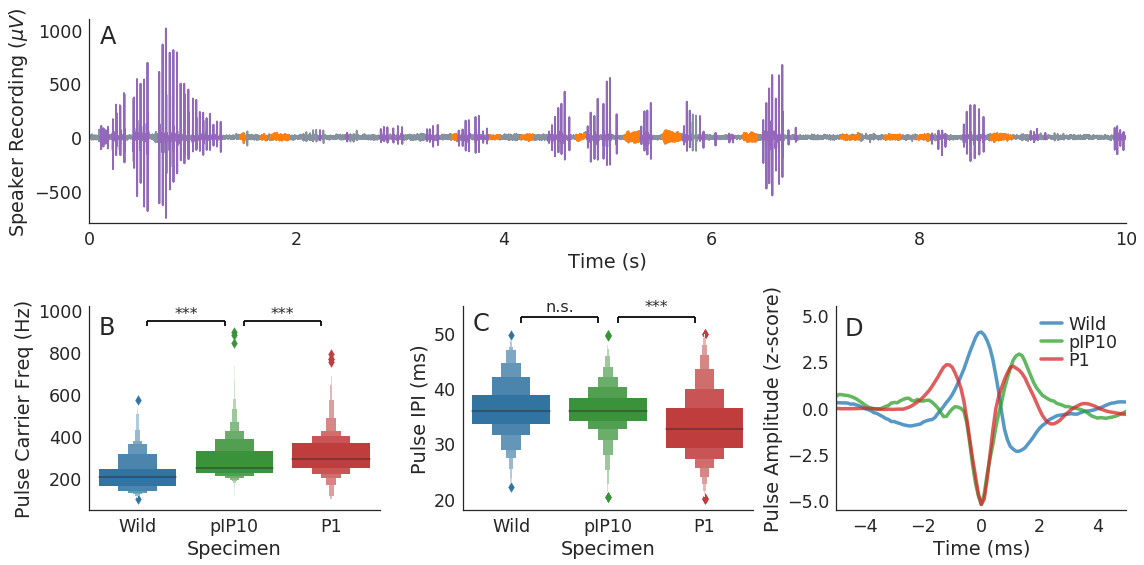

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.75)
%matplotlib inline

## Initialize canvas.
fig = plt.figure(figsize=(16,8))
order = ['Wild', 'pIP10', 'P1']

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot representative recording.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

ax = plt.subplot2grid((2,3),(0,0),colspan=3)

## Load mat file. Extract data.
mat = loadmat('raw/p1_1.mat')
raw, times, sines, pulses = mat['d'], mat['times'], mat['sines'], mat['pulses']
times = times.squeeze()

## Assemble start/stop times.
sine_events = times[sines[:-1].astype(int)-1].T
pulse_events = times[pulses[1:-1].astype(int)-1].T

## Restrict data.
raw = raw[np.logical_and(times >= 10, times <= 20),0]
times = times[np.logical_and(times >= 10, times <= 20)]
sine_events = sine_events[np.logical_and(sine_events[:,0]>=10, sine_events[:,0]<=20)]
pulse_events = pulse_events[np.logical_and(pulse_events[:,0]>=10, pulse_events[:,0]<=20)]

## Plot timeseries.
ax.plot(times, raw, color='#34495e', alpha=0.6)

## Plot sine events.
for t1, t2 in sine_events:
    ix = np.logical_and(times >= t1, times <= t2)
    ax.plot(times[ix], raw[ix], color='#ff7f0e')
    
for t1, t2 in pulse_events:
    ix = np.logical_and(times >= t1, times <= t2)
    ax.plot(times[ix], raw[ix], color='#9467bd')
    
## Add info.
ax.set(xlim=(10,20), xticks=np.arange(10,21,2), xticklabels=np.arange(0,11,2), xlabel='Time (s)',
       ylim=(-800,1100), ylabel=r'Speaker Recording ($\mu V$)')
ax.text(10.1,1050,'A',fontsize=24,ha='left',va='top')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot carrier frequency.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

ax = plt.subplot2grid((2,3),(1,0))

## Plot.
sns.lvplot('Specimen', 'Freq', data=cFREQ, order=order, 
           palette=['#1f77b4', '#2ca02c', '#d62728'])

## Add information.
ax.set(ylim=(50,1020), ylabel='Pulse Carrier Freq (Hz)')   

## Add significance bars.
ax.hlines(950,0.1,0.9)
ax.hlines(950,1.1,1.9)
ax.vlines([0.1,0.9,1.1,1.9], 925, 950)
ax.text(0.5,960,'***',fontsize=16,ha='center')
ax.text(1.5,960,'***',fontsize=16,ha='center')
ax.text(-0.4,975,'B',fontsize=24,ha='left',va='top')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot interpulse interval.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

ax = plt.subplot2grid((2,3),(1,1))

## Plot.
sns.lvplot('Specimen', 'IPI', data=IPI, order=order,
           palette=['#1f77b4', '#2ca02c', '#d62728'])

## Add information.
ax.set(ylim=(18,55), ylabel='Pulse IPI (ms)')   

## Add significance bars.
ax.hlines(53,0.1,0.9)
ax.hlines(53,1.1,1.9)
ax.vlines([0.1,0.9,1.1,1.9], 52, 53)
ax.text(0.5,54,r'n.s.',fontsize=16,ha='center')
ax.text(1.5,54,'***',fontsize=16,ha='center')
ax.text(-0.4,54,'C',fontsize=24,ha='left',va='top')

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plot waveforms.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

ax = plt.subplot2grid((2,3),(1,2))

## Define useful function (z-score).
zscore = lambda arr: (arr - arr.mean()) / arr.std()

## Average across trials within species.
gb = WAVE.groupby(['Specimen','Time']).uV.mean()

for specimen, color in zip(order,['#1f77b4', '#2ca02c', '#d62728']):
    
    ## Normalize waveform (z-score).
    y = zscore(gb[specimen].as_matrix())
    
    ## Recenter waveform at zero (i can haz cheats 2?).
    x = np.linspace(-n_samples/sfreq,n_samples/sfreq,y.size)*1e3
    x -= x[np.argmax(np.abs(y))]
    
    ax.plot(x, y, lw=3.5, label=specimen, color=color, alpha=0.75)

## Add information.
ax.set(xlim=(-5,5), xlabel='Time (ms)', ylim=(-5.5,5.5), ylabel='Pulse Amplitude (z-score)')
ax.legend(loc=1,borderpad=0,labelspacing=0,handlelength=1.25,handletextpad=0.35)
ax.text(-4.7,4.95,'D',fontsize=24,ha='left',va='top')

sns.despine()
plt.tight_layout()
plt.savefig('flysong.png', dpi=300)